In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import random
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
import time

In [2]:
dataset2 = pd.read_csv(
    "https://full-stack-assets.s3.eu-west-3.amazonaws.com/Deployment/get_around_pricing_project.csv", index_col=[0]
)

In [25]:
dataset2.head().to_csv('test.csv')

In [24]:
dataset2.head()

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183


In [56]:
# Write a function that returns two lists containing the categorical variables and the numerical variables in a dataframe
def separate_categorical_and_numerical_variables(df):
    cat_var = []
    num_var = []
    for col in df.columns:
        if df[col].dtype in ['object', 'bool']:
            cat_var.append(col)
        else:
            num_var.append(col)
    return cat_var, num_var

In [57]:
categorical_variables , numerical_variables = separate_categorical_and_numerical_variables(dataset2)

In [58]:
for numvar in  numerical_variables:
    dataset2[numvar] = dataset2[numvar].astype('float')

In [59]:
dataset2[numerical_variables].corr()

,mileage,engine_power,rental_price_per_day
mileage,1.000000,-0.050116,-0.448912
engine_power,-0.050116,1.000000,0.625645
rental_price_per_day,-0.448912,0.625645,1.000000


In [60]:
# Supprimer le target variable de la list des numerical variable
numerical_variables.remove("rental_price_per_day")

In [61]:
for cat_var in categorical_variables:
    display(dataset2[cat_var].value_counts().reset_index())
    print('------------\n')

,model_key,count
0,Citroën,969
1,Renault,916
2,BMW,827
3,Peugeot,642
4,Audi,526
5,Nissan,275
6,Mitsubishi,231
7,Mercedes,97
8,Volkswagen,65
9,Toyota,53


------------



,fuel,count
0,diesel,4641
1,petrol,191
2,hybrid_petrol,8
3,electro,3


------------



,paint_color,count
0,black,1633
1,grey,1175
2,blue,710
3,white,538
4,brown,341
5,silver,329
6,red,52
7,beige,41
8,green,18
9,orange,6


------------



,car_type,count
0,estate,1606
1,sedan,1168
2,suv,1058
3,hatchback,699
4,subcompact,117
5,coupe,104
6,convertible,47
7,van,44


------------



,private_parking_available,count
0,True,2662
1,False,2181


------------



,has_gps,count
0,True,3839
1,False,1004


------------



,has_air_conditioning,count
0,False,3865
1,True,978


------------



,automatic_car,count
0,False,3881
1,True,962


------------



,has_getaround_connect,count
0,False,2613
1,True,2230


------------



,has_speed_regulator,count
0,False,3674
1,True,1169


------------



,winter_tires,count
0,True,4514
1,False,329


------------



In [2]:
# Récupérer l'URI de MLflow depuis les variables d'environnement
mlflow_uri = os.getenv("APP_URI")


In [3]:
os.getenv("BACKEND_STORE_URI")

'postgresql://u49echg04vvrc9:pf10668dce8104b4f5d3228858132565272a79a9744e6dda95d746aa0d15fb37a@cfls9h51f4i86c.cluster-czrs8kj4isg7.us-east-1.rds.amazonaws.com:5432/d5v06kgpkvr138'

In [4]:
mlflow.set_tracking_uri(mlflow_uri)

In [65]:
mlflow.set_tracking_uri(mlflow_uri)  # Remplacez par l'URI de votre MLflow si nécessaire
EXPERIMENT_NAME = "getaround_project"

# Créer ou activer l'expérience
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='s3://bucketdeployment18/getaround_data/1', creation_time=1730680906197, experiment_id='1', last_update_time=1730680906197, lifecycle_stage='active', name='getaround_project', tags={}>

In [66]:
mlflow.sklearn.autolog(log_models=False)

In [67]:
from sklearn.model_selection import train_test_split

# Définir le seuil pour déterminer quelles catégories sont rares
rare_threshold = round(len(dataset2) * 0.01, -1)
rare_indices = set()

# Identification des indices pour les catégories rares dans chaque variable catégorielle
for cat_var in categorical_variables:
    rare_values = (
        dataset2[cat_var]
        .value_counts()[dataset2[cat_var].value_counts() < rare_threshold]
        .index
    )
    rare_indices.update(dataset2[dataset2[cat_var].isin(rare_values)].index)

# Convertir rare_indices en liste pour l'utiliser dans l'indexation de pandas
rare_indices = list(rare_indices)

# Séparer les observations rares et fréquentes
rare_data = dataset2.loc[rare_indices]
frequent_data = dataset2.drop(rare_indices)

# Faire un split pour les données fréquentes
X_train_freq, X_test_freq, y_train_freq, y_test_freq = train_test_split(
    frequent_data.drop(columns="rental_price_per_day"),
    frequent_data["rental_price_per_day"],
    test_size=0.15,
    random_state=42,
)

# Combiner les ensembles
X_train = pd.concat([X_train_freq, rare_data.drop(columns="rental_price_per_day")])
y_train = pd.concat([y_train_freq, rare_data["rental_price_per_day"]])
X_test = pd.concat([X_test_freq, rare_data.drop(columns="rental_price_per_day")])
y_test = pd.concat([y_test_freq, rare_data["rental_price_per_day"]])

# Pre-processing
categorical_transformer = OneHotEncoder(drop="first",handle_unknown="error", sparse_output=False)
numerical_transformer = StandardScaler()


preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_variables),
        ("num", numerical_transformer, numerical_variables),
    ]
)

Simple Linear Regression

In [68]:
# Preprocessing
preprocessor.fit(X_train, y_train)
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [69]:
with mlflow.start_run(run_name="Linear Regression"):
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)
    
    model_lr = LinearRegression()
    model_lr.fit(X_train_transformed, y_train)

    train_pred_lr = model_lr.predict(X_train_transformed)
    test_pred_lr = model_lr.predict(X_test_transformed)

    train_mse_lr = mean_squared_error(y_train, train_pred_lr)
    test_mse_lr = mean_squared_error(y_test, test_pred_lr)
    train_r2_lr = r2_score(y_train, train_pred_lr)
    test_r2_lr = r2_score(y_test, test_pred_lr)

    # Log des métriques et modèle
    mlflow.log_metric("Train MSE", train_mse_lr)
    mlflow.log_metric("Test MSE", test_mse_lr)
    mlflow.log_metric("Train R2", train_r2_lr)
    mlflow.log_metric("Test R2", test_r2_lr)
    
    # Use infer_signature to define input-output schema
    signature = infer_signature(X_train_transformed, train_pred_lr)
    
    # Log model with specified artifact path and registered model name
    mlflow.sklearn.log_model(
        sk_model=model_lr,
        artifact_path="linear_regression_model",
        registered_model_name="getaround_linear_regression",
        signature=signature
    )

2024/11/04 01:01:46 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
Registered model 'getaround_linear_regression' already exists. Creating a new version of this model...
2024/11/04 01:01:51 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: getaround_linear_regression, version 3
Created version '3' of model 'getaround_linear_regression'.
2024/11/04 01:01:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run Linear Regression at: https://getaroundml-125db574e87a.herokuapp.com/#/experiments/1/runs/4e67c548cabf4cf190ba0419583cf8bf.
2024/11/04 01:01:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://getaroundml-125db574e87a.herokuapp.com/#/experiments/1.


In [70]:
# Create a dataframe for evaluation results
evaluation_results = pd.DataFrame(
    {
        "Model": ["Linear Regression"],
        "Train MSE": [train_mse_lr],
        "Test MSE": [test_mse_lr],
        "Train R2": [train_r2_lr],
        "Test R2": [test_r2_lr],
    }
)

In [71]:
evaluation_results

,Model,Train MSE,Test MSE,Train R2,Test R2
0,Linear Regression,333.478935,383.169678,0.71085,0.754889


### Importances

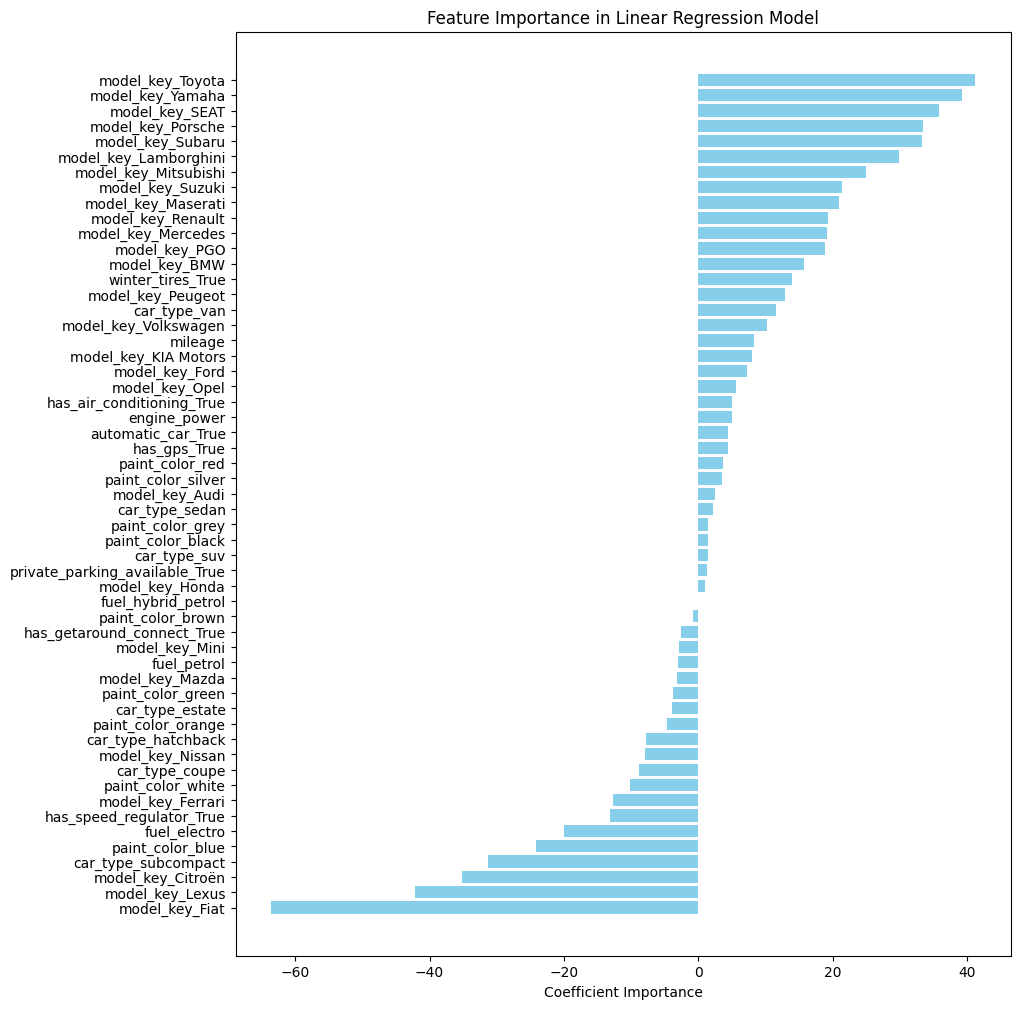

In [72]:

# Pour les variables numériques, leurs noms sont tels quels
num_feature_names = numerical_variables
# Pour les variables catégorielles, récupérez les noms des catégories encodées
cat_feature_names = preprocessor.named_transformers_["cat"].get_feature_names_out(
    categorical_variables
)

# Combiner les noms des variables numériques et catégorielles
feature_names = np.concatenate([num_feature_names, cat_feature_names])

# Extraire les coefficients du modèle de régression linéaire
coefficients = model_lr.coef_

# Créer un DataFrame pour trier les variables par importance
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": coefficients.reshape(feature_names.shape)})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Tracer l'importance des caractéristiques
plt.figure(figsize=(10, 12))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Coefficient Importance")
plt.title("Feature Importance in Linear Regression Model")
plt.gca().invert_yaxis()  # Inverser l'axe y pour afficher les valeurs les plus importantes en haut
plt.show()

In [73]:
models = {
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(),
}

param_grids = {
    "Random Forest": {"n_estimators": [50, 100], "max_depth": np.arange(5,26,5)},
    "Gradient Boosting": {"n_estimators": [50, 100], "learning_rate": np.arange(0.01, 0.25, 0.04)},
    "XGBoost": {"n_estimators": [50, 100], "learning_rate": np.arange(0.01, 0.25, 0.04)},
}

# Dictionnaire pour stocker les meilleurs modèles
best_models = {}

# Boucle pour exécuter GridSearchCV et évaluer chaque modèle restant
for model_name, model in models.items():
    print(f"Training {model_name}...")
    # Set up MLflow run
    with mlflow.start_run(run_name=model_name):

        grid_search = GridSearchCV(
            model, param_grids[model_name], cv=5, scoring="neg_mean_squared_error"
        )
        grid_search.fit(X_train_transformed, y_train)
        best_model = grid_search.best_estimator_
    
        # Stocker le meilleur modèle dans le dictionnaire
        best_models[model_name] = best_model
    
    
        # Prédictions pour le modèle sélectionné
        train_pred = best_model.predict(X_train_transformed)
        test_pred = best_model.predict(X_test_transformed)
    
        # Calcul des métriques pour les données d'entraînement et de test
        train_mse = mean_squared_error(y_train, train_pred)
        test_mse = mean_squared_error(y_test, test_pred)
        train_r2 = r2_score(y_train, train_pred)
        test_r2 = r2_score(y_test, test_pred)

        # Logger les parametres and métriques
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("Train MSE", train_mse)
        mlflow.log_metric("Test MSE", test_mse)
        mlflow.log_metric("Train R2", train_r2)
        mlflow.log_metric("Test R2", test_r2)

        # Logger le model
        signature = infer_signature(X_train_transformed, train_pred)
        model_path = f"{model_name}_model"
        mlflow.sklearn.log_model(
            sk_model=best_model,
            artifact_path=model_path,
            registered_model_name=f"getaround_{model_name}_model",
            signature=signature,
        )
    
        # Ajouter les résultats au DataFrame
        evaluation_results = pd.concat(
            [
                evaluation_results,
                pd.DataFrame(
                    {
                        "Model": [model_name],
                        "Train MSE": [train_mse],
                        "Test MSE": [test_mse],
                        "Train R2": [train_r2],
                        "Test R2": [test_r2],
                    }
                ),
            ],
            ignore_index=True,
        )

2024/11/04 01:01:56 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Training Random Forest...


/opt/conda/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
2024/11/04 01:02:29 INFO mlflow.sklearn.utils: Logging the 5 best runs, 5 runs will be omitted.
Registered model 'getaround_Random Forest_model' already exists. Creating a new version of this model...
2024/11/04 01:02:34 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: getaround_Random Forest_model, version 2
Created version '2' of model 'getaround_Random Forest_model'.
2024/11/04 01:02:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run Random Forest at: https://getaroundml-125db574e87a.herokuapp.com/#/experiments/1/runs/35e8e570bdbe415fbabe14fc46caa853.
2024/11/04 01:02:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://getaroundml-125db574e87a.herokuapp.com/#/experiments/1.
2024/11/04 01:02:35 WARNING mlflow.skl

Training Gradient Boosting...


2024/11/04 01:02:51 INFO mlflow.sklearn.utils: Logging the 5 best runs, 7 runs will be omitted.
Registered model 'getaround_Gradient Boosting_model' already exists. Creating a new version of this model...
2024/11/04 01:02:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: getaround_Gradient Boosting_model, version 2
Created version '2' of model 'getaround_Gradient Boosting_model'.
2024/11/04 01:02:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run Gradient Boosting at: https://getaroundml-125db574e87a.herokuapp.com/#/experiments/1/runs/60239b835f204c688f93c3df873232ea.
2024/11/04 01:02:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://getaroundml-125db574e87a.herokuapp.com/#/experiments/1.
2024/11/04 01:02:55 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Training XGBoost...


2024/11/04 01:02:58 INFO mlflow.sklearn.utils: Logging the 5 best runs, 7 runs will be omitted.
Registered model 'getaround_XGBoost_model' already exists. Creating a new version of this model...
2024/11/04 01:03:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: getaround_XGBoost_model, version 2
Created version '2' of model 'getaround_XGBoost_model'.
2024/11/04 01:03:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBoost at: https://getaroundml-125db574e87a.herokuapp.com/#/experiments/1/runs/cbbd70fa6f724502a277d301659450fc.
2024/11/04 01:03:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://getaroundml-125db574e87a.herokuapp.com/#/experiments/1.


In [74]:
with mlflow.start_run(run_name="Preprocessor"):
    # Use a sample of X_train to infer the output structure of the preprocessor
    X_train_sample = X_train.iloc[:5]  # Take a small sample to avoid large data issues
    transformed_sample = preprocessor.transform(X_train_sample)
    preprocessor_signature = infer_signature(X_train_sample, transformed_sample)

    # Log the fitted preprocessor itself with the inferred signature
    mlflow.sklearn.log_model(
        sk_model=preprocessor,
        artifact_path="preprocessor",
        registered_model_name="getaround_preprocessor",
        signature=preprocessor_signature
    )

2024/11/04 01:03:02 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
Successfully registered model 'getaround_preprocessor'.
2024/11/04 01:03:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: getaround_preprocessor, version 1
Created version '1' of model 'getaround_preprocessor'.
2024/11/04 01:03:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run Preprocessor at: https://getaroundml-125db574e87a.herokuapp.com/#/experiments/1/runs/a73622d206e34c43be7660794faebaf3.
2024/11/04 01:03:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://getaroundml-125db574e87a.herokuapp.com/#/experiments/1.


In [75]:
X_train.iloc[:5]

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires
1158,BMW,174944.0,150.0,petrol,grey,estate,True,True,False,False,True,False,True
3180,Citroën,101646.0,120.0,diesel,brown,sedan,True,True,True,False,True,True,True
2626,Renault,134329.0,135.0,diesel,black,sedan,True,True,False,True,True,True,True
567,Citroën,77499.0,160.0,diesel,white,estate,False,False,False,False,False,False,True
451,Audi,155270.0,190.0,diesel,black,estate,False,True,True,False,True,False,True


In [76]:
evaluation_results

,Model,Train MSE,Test MSE,Train R2,Test R2
0,Linear Regression,333.478935,383.169678,0.710850,0.754889
1,Random Forest,40.405141,179.941756,0.964966,0.884893
2,Gradient Boosting,210.762493,219.633961,0.817254,0.859502
3,XGBoost,96.217784,159.662949,0.916572,0.897865


In [77]:
print(
    "Parmi les modèles évalués, le Random Forest présente la meilleure performance en termes de MSE d'entraînement, mais montre des signes de surajustement avec un MSE de test plus élevé.\nLes modèles XGBoost et Gradient Boosting offrent un bon équilibre entre ajustement et généralisation.\nXGBoost, avec son MSE de test de 159.66 et un R² de 0.898, sera retenu comme le meilleur modèle pour effectuer les prédictions."
)

Parmi les modèles évalués, le Random Forest présente la meilleure performance en termes de MSE d'entraînement, mais montre des signes de surajustement avec un MSE de test plus élevé.
Les modèles XGBoost et Gradient Boosting offrent un bon équilibre entre ajustement et généralisation.
XGBoost, avec son MSE de test de 159.66 et un R² de 0.898, sera retenu comme le meilleur modèle pour effectuer les prédictions.


In [78]:
optimal_model_name = evaluation_results.sort_values(by=['Test MSE', 'Test R2'], ascending=True).reset_index(drop=True).loc[0]["Model"]

In [79]:
optimal_model = best_models[optimal_model_name]

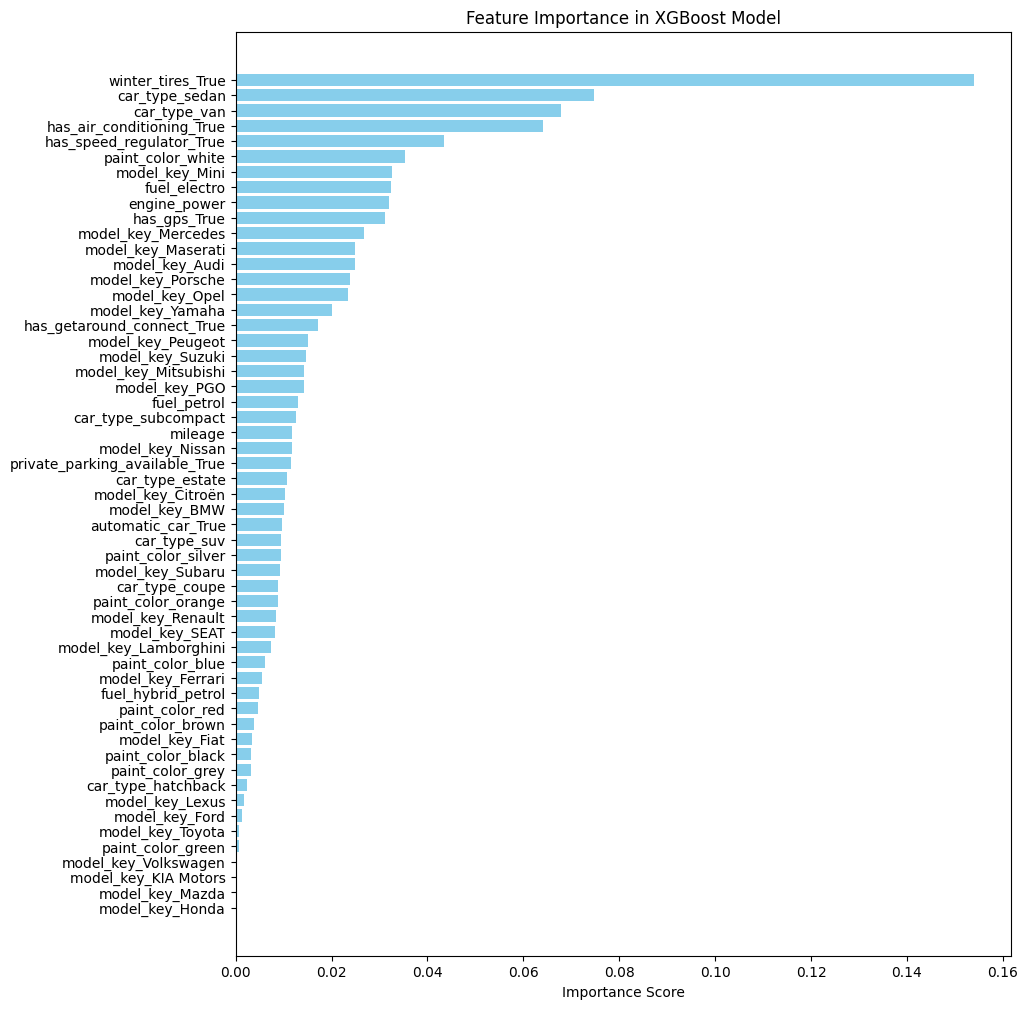

In [112]:
# Assuming 'optimal_model' is the best XGBoost model obtained from previous code
# Get feature importances
importances = optimal_model.feature_importances_

# Get the names of the features
num_feature_names = numerical_variables
cat_feature_names = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_variables)

# Combine feature names
feature_names = np.concatenate([num_feature_names, cat_feature_names])

# Create a DataFrame for the importance values
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plotting
plt.figure(figsize=(10, 12))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Importance Score")
plt.title("Feature Importance in XGBoost Model")
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

# Check Prediction with MLflow

In [81]:
random_index = random.sample(range(0,len(dataset2)), 5)

In [82]:
test_df = dataset2.loc[random_index]
test_df["prediction"] = optimal_model.predict(preprocessor.transform(test_df))

In [83]:
test_df

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day,prediction
4067,Nissan,88875.0,100.0,diesel,white,suv,True,True,False,False,False,False,True,115.0,118.516716
1002,Audi,188713.0,190.0,diesel,black,estate,True,False,False,False,True,True,True,141.0,137.514740
976,Citroën,135980.0,120.0,diesel,grey,estate,True,True,False,False,True,True,True,122.0,121.710579
4399,Mitsubishi,203919.0,173.0,diesel,black,suv,True,True,True,True,True,False,True,103.0,124.412224
4424,BMW,137321.0,190.0,diesel,grey,suv,True,True,True,True,True,True,True,152.0,150.637955


In [9]:
input =     {
      "model_key": "Toyota",
      "mileage": 25000,
      "engine_power": 130,
      "fuel": "diesel",
      "paint_color": "red",
      "car_type": "sedan",
      "private_parking_available": True,
      "has_gps": True,
      "has_air_conditioning": True,
      "automatic_car": True,
      "has_getaround_connect": True,
      "has_speed_regulator": True,
      "winter_tires": True
    }

In [10]:
input_df = pd.DataFrame([input])

In [11]:
input_df

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires
0,Toyota,25000,130,diesel,red,sedan,True,True,True,True,True,True,True


In [13]:
def prediction(data):
    """
    Make prediction
    """

    # Preprocessing
    preprocessor = "runs:/a73622d206e34c43be7660794faebaf3/preprocessor"

    # Load model
    preprocess = mlflow.sklearn.load_model(preprocessor)

    # Load model
    logged_model = "runs:/cbbd70fa6f724502a277d301659450fc/XGBoost_model"

    # Load model as a PyFuncModel.
    loaded_model = mlflow.pyfunc.load_model(logged_model)

    # Predict on a Pandas DataFrame.
    prediction = loaded_model.predict(pd.DataFrame(preprocess.transform(data)))
    print("_____\n")
    print(prediction)
    print("_____\n")

    return prediction[0]




In [14]:
prediction(input_df)

_____

[145.71324]
_____



np.float32(145.71324)